In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = './'
itrp_df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
itrp_df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
itrp_df_tpm.shape, itrp_df_label.shape

FileNotFoundError: [Errno 2] No such file or directory: './ITRP.PATIENT.TABLE'

In [3]:
ls -lh

total 0
drwxrwxr-x 2 was966 was966 4.0K Feb 20 17:44 00_within-cohort-leave-one-out/
drwxrwxr-x 2 was966 was966 4.0K Feb 20 17:04 01_all-cohort-to-cohort-transfer/
drwxrwxr-x 2 was966 was966 4.0K Feb 20 12:09 02_all-leave-one-cohort-out/
drwxr-xr-x 2 was966 was966 4.0K Feb 19 23:22 all-cohort-2-cohort-transfer/
drwxrwxr-x 2 was966 was966 4.0K Feb 19 17:33 old/
drwxrwxr-x 2 was966 was966 4.0K Feb 19 17:33 zzz_skcm-leave-one-cohort-out/


## 00. Data stractified by antibody targets
same cancer type, same sequencer, different antibodies

In [4]:
itrp_df_label.groupby(['cancer_type', 'sequencer', 'ICI_target_map']).size().unstack()[['PD1', 'PD-L1', 'CTLA4']]

ICI_target_map                PD1  PD-L1  CTLA4
cancer_type sequencer                          
BLCA        HiSeq2500         NaN  298.0    NaN
            HiSeq4000         NaN   21.0    NaN
            NovaSeq6000      51.0   38.0    NaN
GBM         HiSeq2000        25.0    NaN    NaN
KIRC        HiSeq2000        21.0    2.0    NaN
            HiSeq2500         6.0  165.0    NaN
LUAD        HiSeq2500        82.0    6.0    NaN
LUSC        HiSeq2500        24.0    1.0    NaN
SKCM        HiSeq2000        26.0    NaN    NaN
            HiSeq2000/2500   51.0    NaN    NaN
            HiSeq2500       161.0    3.0   57.0
STAD        HiSeq2500        45.0    NaN    NaN

In [5]:
## group 1
cancer = ['BLCA']
sequencer = ['NovaSeq6000']
ICI_target = ['PD1', 'PD-L1']
group1 = [cancer, sequencer, ICI_target]

## group 2
cancer = ['SKCM']
sequencer = ['HiSeq2500']
ICI_target = ['PD1', 'CTLA4']
group2 = [cancer, sequencer, ICI_target]

## group 3
cancer = ['KIRC']
sequencer = ['HiSeq2500']
ICI_target = ['PD1', 'PD-L1']
group3 = [cancer, sequencer, ICI_target]

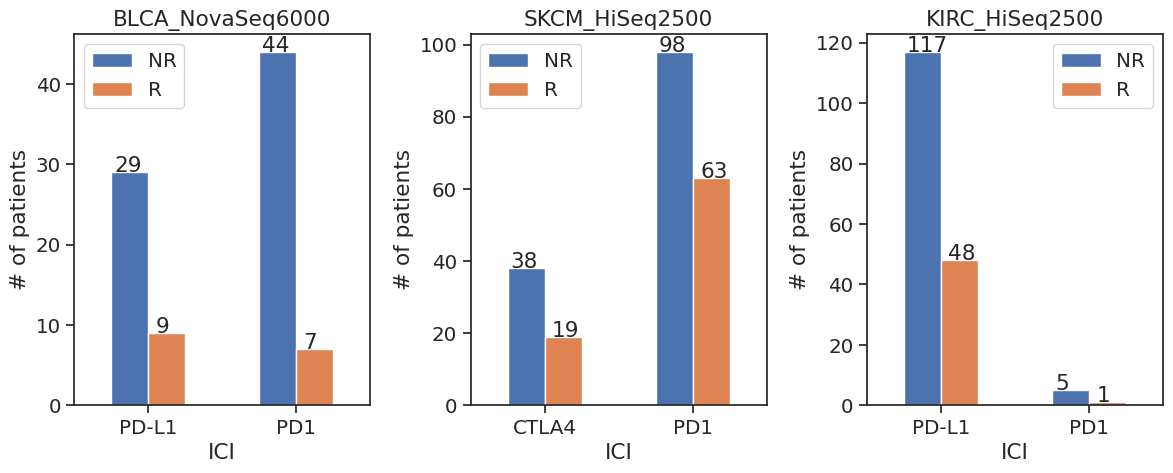

In [6]:
res = []

fig, axes = plt.subplots(figsize=(12, 5), ncols=3)
for group, ax in zip([group1, group2, group3], axes):
    cancer, sequencer, ICI_target  = group
    key = '_'.join(cancer + sequencer)
    sidx = itrp_df_label.cancer_type.isin(cancer) & itrp_df_label.sequencer.isin(sequencer)  & itrp_df_label.ICI_target_map.isin(ICI_target)
    data_used = itrp_df_label[sidx]
    data_used['key'] = key

    bar_data = data_used.groupby(['ICI_target_map', 'response_label']).size().unstack()
    bar_data.plot(kind='bar', ax=ax, legend=False)
    
    for i in range(len(bar_data)):
        b1 = bar_data.iloc[i]
        for v, g in zip(b1, [-0.23, 0.05]):
            ax.text(i+g, v, str(v))

    
    ax.title.set_text(key)
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('ICI')
    ax.set_ylabel('# of patients')
    res.append(data_used)

fig.tight_layout()

## 01. Data stractified by sequencer
same cancer type, same target, different sequencer

In [7]:
itrp_df_label.groupby(['cancer_type', 'ICI_target_map',  'sequencer', ]).size().unstack()

sequencer                   HiSeq2000  HiSeq2000/2500  HiSeq2500  HiSeq4000  \
cancer_type ICI_target_map                                                    
BLCA        PD-L1                 NaN             NaN      298.0       21.0   
            PD1                   NaN             NaN        NaN        NaN   
GBM         PD1                  25.0             NaN        NaN        NaN   
KIRC        PD-L1                 2.0             NaN      165.0        NaN   
            PD1                  21.0             NaN        6.0        NaN   
            PD1 + CTLA4           4.0             NaN        NaN        NaN   
LUAD        Other                 NaN             NaN        6.0        NaN   
            PD-L1                 NaN             NaN        6.0        NaN   
            PD1                   NaN             NaN       82.0        NaN   
            PD1 + CTLA4           NaN             NaN        8.0        NaN   
LUSC        Other                 NaN             NaN        1.0        NaN   
            PD-L1                 NaN             NaN        1.0        NaN   
            PD1                   NaN             NaN       24.0        NaN   
            PD1 + CTLA4           NaN             NaN        2.0        NaN   
SKCM        CTLA4                 NaN             NaN       57.0        NaN   
            Other                 NaN             NaN        2.0        NaN   
            PD-L1                 NaN             NaN        3.0        NaN   
            PD1                  26.0            51.0      161.0        NaN   
            PD1 + CTLA4           NaN             NaN       34.0        NaN   
STAD        PD1                   NaN             NaN       45.0        NaN   

sequencer                   NovaSeq6000  
cancer_type ICI_target_map               
BLCA        PD-L1                  38.0  
            PD1                    51.0  
GBM         PD1                     NaN  
KIRC        PD-L1                   NaN  
            PD1                     NaN  
            PD1 + CTLA4             NaN  
LUAD        Other                   NaN  
            PD-L1                   NaN  
            PD1                     NaN  
            PD1 + CTLA4             NaN  
LUSC        Other                   NaN  
            PD-L1                   NaN  
            PD1                     NaN  
            PD1 + CTLA4             NaN  
SKCM        CTLA4                   NaN  
            Other                   NaN  
            PD-L1                   NaN  
            PD1                     NaN  
            PD1 + CTLA4             NaN  
STAD        PD1                     NaN

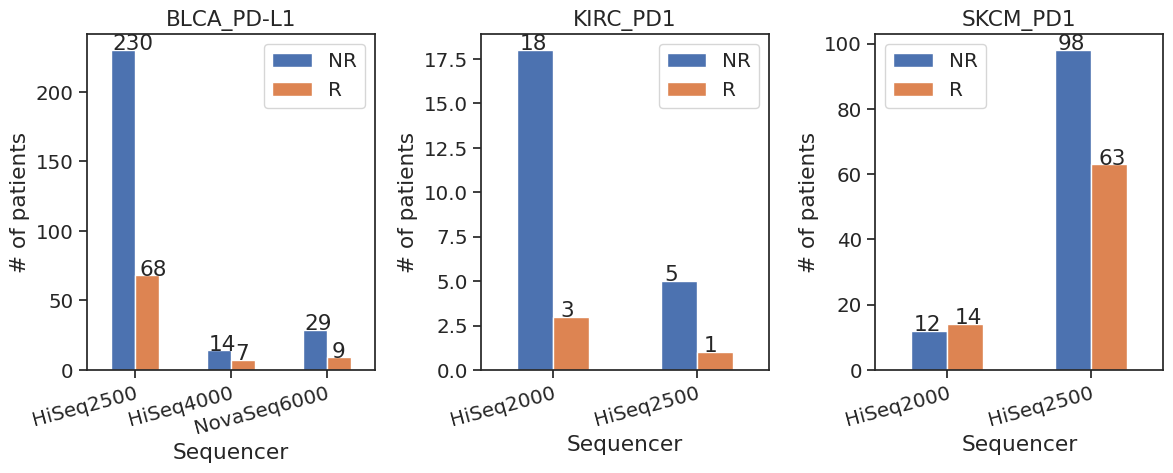

In [8]:
## group 1
cancer = ['BLCA',]
sequencer = ['HiSeq2500',  'HiSeq4000', 'NovaSeq6000']
ICI_target = ['PD-L1']
group1 = [cancer, sequencer, ICI_target]


## group 2
cancer = ['KIRC']
sequencer = ['HiSeq2000', 'HiSeq2500']
ICI_target = ['PD1']
group2 = [cancer, sequencer, ICI_target]


## group 2
cancer = ['SKCM']
sequencer = ['HiSeq2000', 'HiSeq2500']
ICI_target = ['PD1']
group3 = [cancer, sequencer, ICI_target]



res = []
fig, axes = plt.subplots(figsize=(12, 5), ncols=3)
for group, ax in zip([group1, group2, group3], axes):
    cancer, sequencer, ICI_target  = group
    key = '_'.join(cancer + ICI_target)
    sidx = itrp_df_label.cancer_type.isin(cancer) & itrp_df_label.sequencer.isin(sequencer)  & itrp_df_label.ICI_target_map.isin(ICI_target)
    data_used = itrp_df_label[sidx]
    data_used['key'] = key

    bar_data = data_used.groupby(['sequencer', 'response_label']).size().unstack()
    bar_data.plot(kind='bar', ax=ax, legend=False)
    
    for i in range(len(bar_data)):
        b1 = bar_data.iloc[i] #.astype(int)
        for v, g in zip(b1, [-0.23, 0.05]):
            ax.text(i+g, v, str(v))

    
    ax.title.set_text(key)
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('Sequencer')
    ax.set_ylabel('# of patients')
    res.append(data_used)
    
    ax.set_xticklabels(
        sequencer, 
        rotation=15, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke

fig.tight_layout()

## 02. Data stractified by cancer_type
same target, same sequencer, different cancer_type

In [9]:
itrp_df_label.groupby(['ICI_target_map', 'sequencer', 'cancer_type']).size().unstack()

cancer_type                     BLCA   GBM   KIRC  LUAD  LUSC   SKCM  STAD
ICI_target_map sequencer                                                  
CTLA4          HiSeq2500         NaN   NaN    NaN   NaN   NaN   57.0   NaN
Other          HiSeq2500         NaN   NaN    NaN   6.0   1.0    2.0   NaN
PD-L1          HiSeq2000         NaN   NaN    2.0   NaN   NaN    NaN   NaN
               HiSeq2500       298.0   NaN  165.0   6.0   1.0    3.0   NaN
               HiSeq4000        21.0   NaN    NaN   NaN   NaN    NaN   NaN
               NovaSeq6000      38.0   NaN    NaN   NaN   NaN    NaN   NaN
PD1            HiSeq2000         NaN  25.0   21.0   NaN   NaN   26.0   NaN
               HiSeq2000/2500    NaN   NaN    NaN   NaN   NaN   51.0   NaN
               HiSeq2500         NaN   NaN    6.0  82.0  24.0  161.0  45.0
               NovaSeq6000      51.0   NaN    NaN   NaN   NaN    NaN   NaN
PD1 + CTLA4    HiSeq2000         NaN   NaN    4.0   NaN   NaN    NaN   NaN
               HiSeq2500         NaN   NaN    NaN   8.0   2.0   34.0   NaN

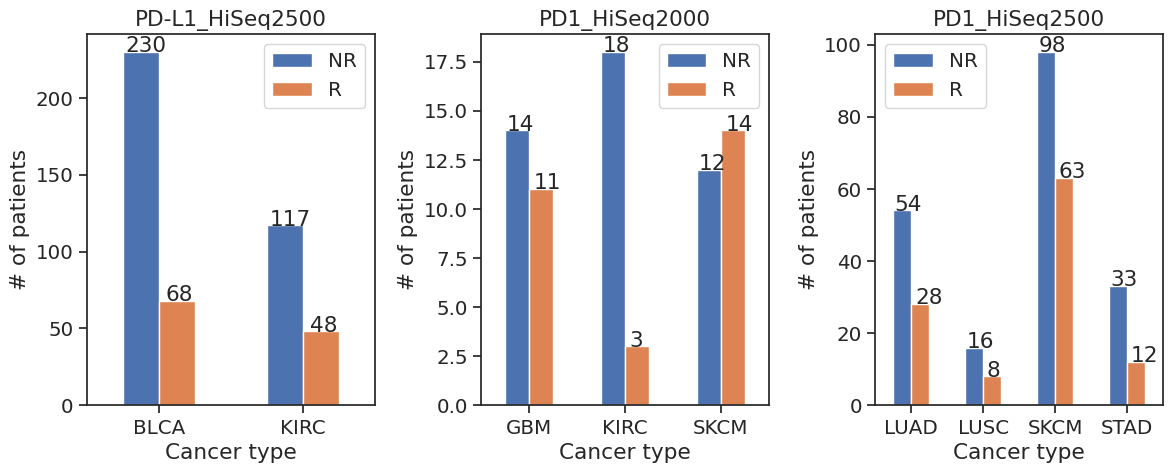

In [10]:
## group 1
cancer = ['BLCA', 'KIRC']
sequencer = ['HiSeq2500']
ICI_target = ['PD-L1']
group1 = [cancer, sequencer, ICI_target]

## group 2
cancer = ['GBM', 'KIRC', 'SKCM']
sequencer = ['HiSeq2000']
ICI_target = ['PD1']
group2 = [cancer, sequencer, ICI_target]

## group 3
cancer = ['LUAD', 'LUSC', 'SKCM', 'STAD']
sequencer = ['HiSeq2500']
ICI_target = ['PD1']
group3 = [cancer, sequencer, ICI_target]



res = []
fig, axes = plt.subplots(figsize=(12, 5), ncols=3)
for group, ax in zip([group1, group2, group3], axes):
    cancer, sequencer, ICI_target  = group
    key = '_'.join(ICI_target + sequencer)
    sidx = itrp_df_label.cancer_type.isin(cancer) & itrp_df_label.sequencer.isin(sequencer)  & itrp_df_label.ICI_target_map.isin(ICI_target)
    data_used = itrp_df_label[sidx]
    data_used['key'] = key

    bar_data = data_used.groupby(['cancer_type', 'response_label']).size().unstack()
    bar_data.plot(kind='bar', ax=ax, legend=False)
    
    for i in range(len(bar_data)):
        b1 = bar_data.iloc[i] #.astype(int)
        for v, g in zip(b1, [-0.23, 0.05]):
            ax.text(i+g, v, str(v))

    ax.title.set_text(key)
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('Cancer type')
    ax.set_ylabel('# of patients')
    res.append(data_used)

fig.tight_layout()